## Описание проекта, загрузка и подготовка данных

### Введение
______
**Название проекта**  

Сегментация медицинских снимков
_____

**Цель исследования**  

Произвести сегментацию медицинских снимков на основе сетей `SegNet` и `U-Net` с использованием различных лоссов
_______
**Задачи исследования**

- Провести необходимое преобразование входных данных
- Провести обработку дисбаланса классов
- Сформировать модель
- Обучить модель и сделать предсказание на тестовом наборе данных
_____
**Исходные данные**  

Датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html) (Automatic computer-based Diagnosis system for Dermoscopy Images)    
Фотографии содержат два типа поражений кожи: меланома и родинки    

`X.bmp` — изображение, которое нужно сегментировать    
`X_lesion.bmp` — результат сегментации

###  Установка и импорт библиотек

In [206]:
!pip install torchmetrics -q
!pip install segmentation-models-pytorch -q

In [207]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os

from skimage.io import imread
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex
from torchvision import models
from time import time
from matplotlib import rcParams
from tqdm.notebook import tqdm
from segmentation_models_pytorch.losses import FocalLoss, DiceLoss

rcParams['figure.figsize'] = (15,4)

### Загрузка данных

In [208]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=96789cf3-b0e1-412b-9a5e-d18e763a0988
To: /kaggle/working/PH2Dataset.rar
100%|█████████████████████████████████████████| 162M/162M [00:01<00:00, 114MB/s]


In [209]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Загрузим изображения и маски поражений кожи из датасета PH2

In [210]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изменим размер изображений на $256\times256 $ пикселей и нормализуем их

In [211]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [212]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Выведем несколько изображений

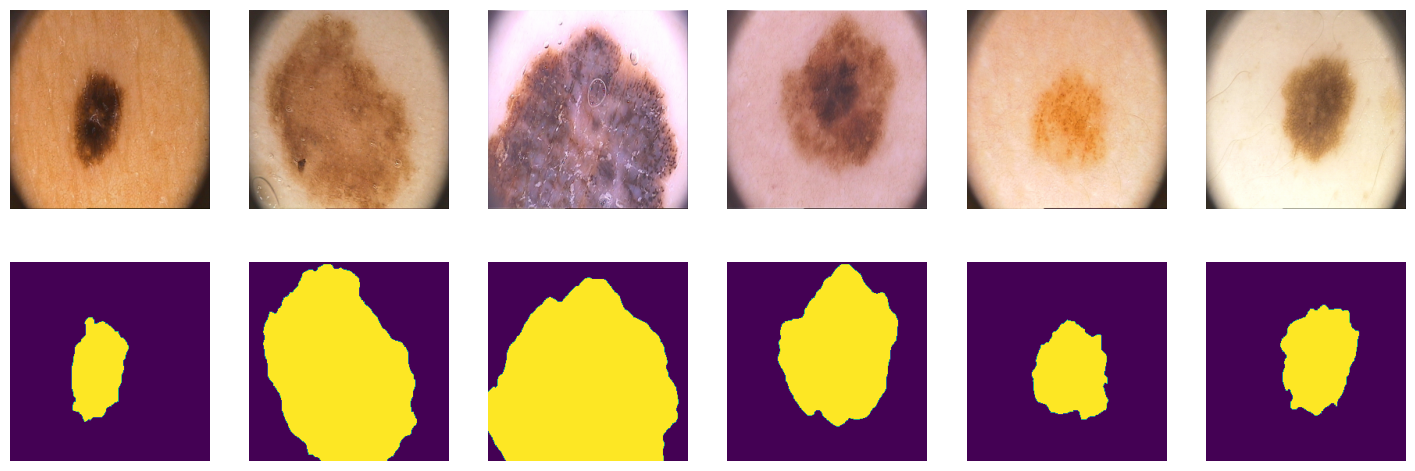

In [213]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим 200 снимков в соотношении 100/50/50 для обучения, валидации и теста соответственно

In [214]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [215]:
print(len(tr), len(val), len(ts))

100 50 50


### Подготовим данные с помощью PyTorch DataLoader

In [216]:
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [217]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Реализация модели SegNet

Для оценки качества будем использовать метрику IoU

In [218]:
iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

### SegNet архитектура

In [219]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # Encoder
        self.enc_conv11 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.enc_bn11 = nn.BatchNorm2d(64)
        self.enc_conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc_bn12 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_bn21 = nn.BatchNorm2d(128)
        self.enc_conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_bn22 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_bn31 = nn.BatchNorm2d(256)
        self.enc_conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_bn32 = nn.BatchNorm2d(256)
        self.enc_conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_bn33 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_bn41 = nn.BatchNorm2d(512)
        self.enc_conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_bn42 = nn.BatchNorm2d(512)
        self.enc_conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_bn43 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Bottleneck
        self.enc_conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_bn51 = nn.BatchNorm2d(512)
        self.enc_conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_bn52 = nn.BatchNorm2d(512)
        self.enc_conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_bn53 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Decoder (upsampling)
        self.unpool5 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dec_bn53 = nn.BatchNorm2d(512)
        self.dec_conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dec_bn52 = nn.BatchNorm2d(512)
        self.dec_conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dec_bn51 = nn.BatchNorm2d(512)

        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dec_bn43 = nn.BatchNorm2d(512)
        self.dec_conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dec_bn42 = nn.BatchNorm2d(512)
        self.dec_conv41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_bn41 = nn.BatchNorm2d(256)

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.dec_bn33 = nn.BatchNorm2d(256)
        self.dec_conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.dec_bn32 = nn.BatchNorm2d(256)
        self.dec_conv31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_bn31 = nn.BatchNorm2d(128)

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dec_bn22 = nn.BatchNorm2d(128)
        self.dec_conv21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_bn21 = nn.BatchNorm2d(64)

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec_bn12 = nn.BatchNorm2d(64)
        self.dec_conv11 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_bn11(self.enc_conv11(x)))
        x = F.relu(self.enc_bn12(self.enc_conv12(x)))
        x, indices1 = self.pool1(x)

        x = F.relu(self.enc_bn21(self.enc_conv21(x)))
        x = F.relu(self.enc_bn22(self.enc_conv22(x)))
        x, indices2 = self.pool2(x)

        x = F.relu(self.enc_bn31(self.enc_conv31(x)))
        x = F.relu(self.enc_bn32(self.enc_conv32(x)))
        x = F.relu(self.enc_bn33(self.enc_conv33(x)))
        x, indices3 = self.pool3(x)

        x = F.relu(self.enc_bn41(self.enc_conv41(x)))
        x = F.relu(self.enc_bn42(self.enc_conv42(x)))
        x = F.relu(self.enc_bn43(self.enc_conv43(x)))
        x, indices4 = self.pool4(x)

        # Bottleneck
        x = F.relu(self.enc_bn51(self.enc_conv51(x)))
        x = F.relu(self.enc_bn52(self.enc_conv52(x)))
        x = F.relu(self.enc_bn53(self.enc_conv53(x)))
        x, indices5 = self.pool5(x)

        # Decoder
        x = self.unpool5(x, indices5)
        x = F.relu(self.dec_bn53(self.dec_conv53(x)))
        x = F.relu(self.dec_bn52(self.dec_conv52(x)))
        x = F.relu(self.dec_bn51(self.dec_conv51(x)))

        x = self.unpool4(x, indices4)
        x = F.relu(self.dec_bn43(self.dec_conv43(x)))
        x = F.relu(self.dec_bn42(self.dec_conv42(x)))
        x = F.relu(self.dec_bn41(self.dec_conv41(x)))

        x = self.unpool3(x, indices3)
        x = F.relu(self.dec_bn33(self.dec_conv33(x)))
        x = F.relu(self.dec_bn32(self.dec_conv32(x)))
        x = F.relu(self.dec_bn31(self.dec_conv31(x)))

        x = self.unpool2(x, indices2)
        x = F.relu(self.dec_bn22(self.dec_conv22(x)))
        x = F.relu(self.dec_bn21(self.dec_conv21(x)))

        x = self.unpool1(x, indices1)
        x = F.relu(self.dec_bn12(self.dec_conv12(x)))
        output = self.dec_conv11(x)

        return output # no activation

In [220]:
segnet_model = SegNet().to(device)

### Обучение модели SegNet

Функция обучения модели SegNet

In [221]:
def train(model, train_dataloader, valid_dataloader, criterion, optimizer, device, epochs):
    train_losses = []
    valid_losses = []
    valid_iou_scores = []

    model_name = model.__class__.__name__

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x_batch, y_batch in tqdm(train_dataloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss = train_loss / len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0
        valid_iou = 0.0

        with torch.no_grad():
            for x_batch, y_batch in valid_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)

                valid_loss += loss.item()
                valid_iou += iou_score(outputs, y_batch)

        valid_loss = valid_loss / len(valid_dataloader)
        valid_losses.append(valid_loss)

        valid_iou = valid_iou / len(valid_dataloader)
        valid_iou_scores.append(valid_iou.cpu().detach().numpy())

        torch.save(model.state_dict(), f'{model_name}_epoch_{epoch+1}.pt')

        print(f'Epoch [{epoch+1}/{epochs}] Training Loss: {train_loss:.4f} Validation Loss: {valid_loss:.4f} Validation IoU: {valid_iou:.4f}')

    return train_losses, valid_losses, valid_iou_scores

Функция отображения результатов обучения

In [222]:
def visualize_metrics(train_losses, valid_losses, valid_iou_scores, epochs=epochs):
    epochs = range(1, epochs + 1)

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Training Loss')
    plt.plot(epochs, valid_losses, 'o-', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_iou_scores, 'o-', label='Validation IoU')
    plt.title('Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

Обучение модели **SegNet**

In [223]:
segnet_model = SegNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(segnet_model.parameters(), lr=1e-4)
epochs = 30

train_losses, valid_losses, valid_iou_scores = train(
    segnet_model,
    train_dataloader,
    valid_dataloader,
    criterion,
    optimizer,
    device,
    epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/30] Training Loss: 0.6765 Validation Loss: 0.7008 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/30] Training Loss: 0.5661 Validation Loss: 0.6917 Validation IoU: 0.1886


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/30] Training Loss: 0.4792 Validation Loss: 0.6730 Validation IoU: 0.0002


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/30] Training Loss: 0.4354 Validation Loss: 0.6468 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/30] Training Loss: 0.3620 Validation Loss: 0.6246 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/30] Training Loss: 0.3377 Validation Loss: 0.6135 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/30] Training Loss: 0.3029 Validation Loss: 0.6197 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/30] Training Loss: 0.2724 Validation Loss: 0.6403 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/30] Training Loss: 0.2400 Validation Loss: 0.5658 Validation IoU: 0.1473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/30] Training Loss: 0.2258 Validation Loss: 0.5161 Validation IoU: 0.2752


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/30] Training Loss: 0.2185 Validation Loss: 0.3310 Validation IoU: 0.5917


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/30] Training Loss: 0.1890 Validation Loss: 0.2791 Validation IoU: 0.6793


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/30] Training Loss: 0.2030 Validation Loss: 0.2413 Validation IoU: 0.7359


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/30] Training Loss: 0.2043 Validation Loss: 0.2057 Validation IoU: 0.7968


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/30] Training Loss: 0.1905 Validation Loss: 0.2065 Validation IoU: 0.7977


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/30] Training Loss: 0.1720 Validation Loss: 0.1971 Validation IoU: 0.8118


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/30] Training Loss: 0.1794 Validation Loss: 0.2013 Validation IoU: 0.8056


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/30] Training Loss: 0.1536 Validation Loss: 0.1771 Validation IoU: 0.8296


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/30] Training Loss: 0.1642 Validation Loss: 0.1724 Validation IoU: 0.8312


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/30] Training Loss: 0.1265 Validation Loss: 0.1739 Validation IoU: 0.8282


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/30] Training Loss: 0.1235 Validation Loss: 0.1632 Validation IoU: 0.8439


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/30] Training Loss: 0.1210 Validation Loss: 0.1603 Validation IoU: 0.8461


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/30] Training Loss: 0.1158 Validation Loss: 0.1656 Validation IoU: 0.8368


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/30] Training Loss: 0.1036 Validation Loss: 0.1531 Validation IoU: 0.8521


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/30] Training Loss: 0.0935 Validation Loss: 0.1482 Validation IoU: 0.8580


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/30] Training Loss: 0.0933 Validation Loss: 0.1485 Validation IoU: 0.8513


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/30] Training Loss: 0.0927 Validation Loss: 0.1490 Validation IoU: 0.8568


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/30] Training Loss: 0.0835 Validation Loss: 0.1555 Validation IoU: 0.8413


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/30] Training Loss: 0.0786 Validation Loss: 0.1548 Validation IoU: 0.8464


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/30] Training Loss: 0.0724 Validation Loss: 0.1433 Validation IoU: 0.8628


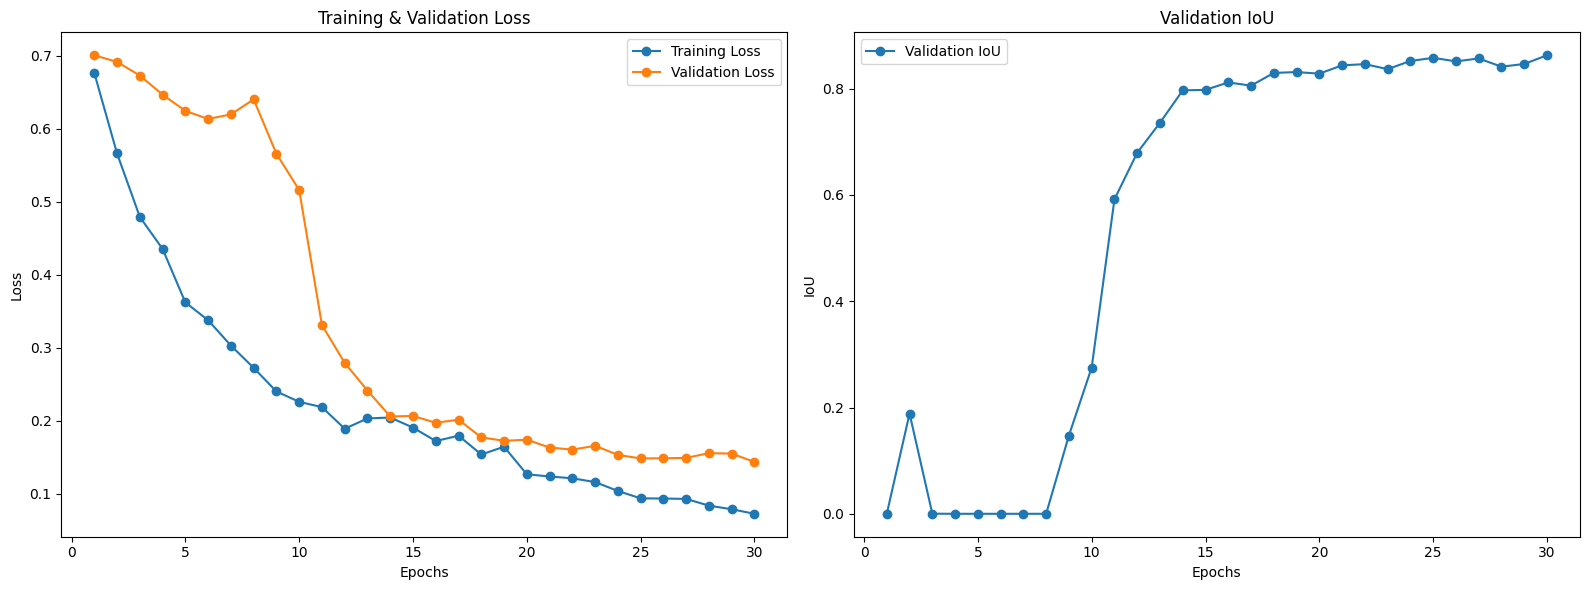

In [224]:
visualize_metrics(train_losses, valid_losses, valid_iou_scores, epochs=epochs)

### Тестирование модели SegNet

Функция тестирования модели SegNet

In [225]:
def test(model, test_dataloader, criterion, device, num_images_to_display=5):
    model.eval()
    test_loss = 0.0
    iou_scores = []
    visualize = True

    fig, axes = plt.subplots(3, num_images_to_display, figsize=(10, 5))
    fig.tight_layout()

    with torch.no_grad():
        for x_batch, y_batch in test_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            test_loss += loss.item()

            iou_scores.append(iou_score(outputs, y_batch).cpu().tolist())

            if visualize:
                for i in range(num_images_to_display):

                    original_image = x_batch[i].permute(1, 2, 0).cpu().detach().numpy()
                    predicted_mask = (outputs[i].cpu().detach().numpy() > 0.5).astype(np.uint8)
                    original_mask = y_batch[i].cpu().detach().numpy().astype(np.uint8)

                    axes[0, i].imshow(original_image)
                    axes[0, i].set_title(f'Image {i + 1}')
                    axes[0, i].axis('off')
                    axes[1, i].imshow(predicted_mask.squeeze())
                    axes[1, i].set_title('Predicted Mask')
                    axes[1, i].axis('off')
                    axes[2, i].imshow(original_mask.squeeze())
                    axes[2, i].set_title('Original Mask')
                    axes[2, i].axis('off')

                visualize = False

    avg_test_loss = test_loss / len(test_dataloader)
    avg_iou_score = np.mean(iou_scores)

    print(f'Test Loss: {avg_test_loss:.4f} Average IoU: {avg_iou_score:.4f}')

    plt.show()

Test Loss: 0.1756 Average IoU: 0.8304


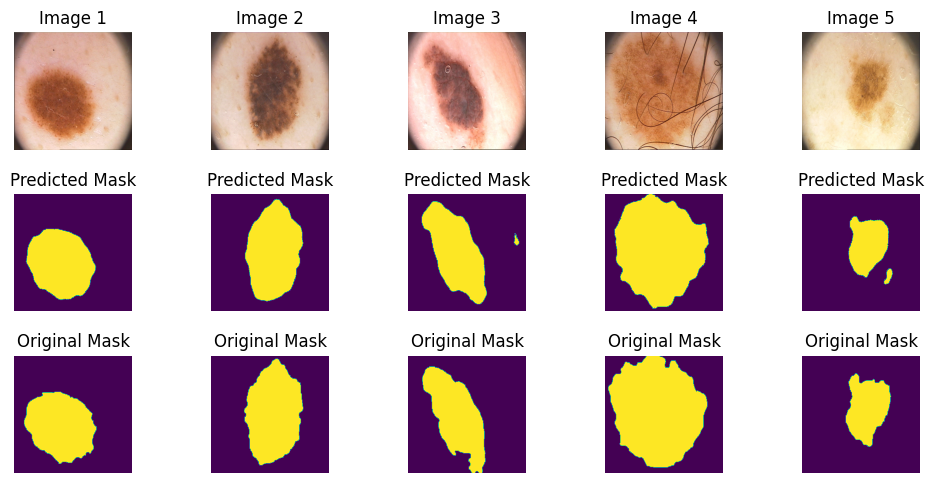

In [226]:
segnet_model = SegNet().to(device)
segnet_model.load_state_dict(torch.load('SegNet_epoch_30.pt', weights_only=True))
test(segnet_model, test_dataloader, criterion, device)

## Обучение SegNet на разных лоссах

Для анализа обучения модели на разных лоссах будем дополнительно использовать:
- `Dice Loss`
- `Focal Loss`
- написанную самостоятельно функцию потерь `Tversky Loss`

### Dice Loss

In [227]:
segnet_model = SegNet().to(device)
criterion = DiceLoss(mode='binary')
optimizer = optim.Adam(segnet_model.parameters(), lr=1e-4)
train_losses, valid_losses, valid_iou_scores = train(
    segnet_model,
    train_dataloader,
    valid_dataloader,
    criterion,
    optimizer,
    device,
    epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/30] Training Loss: 0.5224 Validation Loss: 0.6237 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/30] Training Loss: 0.4485 Validation Loss: 0.6255 Validation IoU: 0.2250


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/30] Training Loss: 0.3972 Validation Loss: 0.6294 Validation IoU: 0.0066


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/30] Training Loss: 0.3648 Validation Loss: 0.6365 Validation IoU: 0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/30] Training Loss: 0.3436 Validation Loss: 0.6465 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/30] Training Loss: 0.3179 Validation Loss: 0.6614 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/30] Training Loss: 0.3150 Validation Loss: 0.6789 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/30] Training Loss: 0.2823 Validation Loss: 0.6087 Validation IoU: 0.2135


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/30] Training Loss: 0.2654 Validation Loss: 0.4879 Validation IoU: 0.4588


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/30] Training Loss: 0.2494 Validation Loss: 0.4864 Validation IoU: 0.4281


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/30] Training Loss: 0.2322 Validation Loss: 0.3390 Validation IoU: 0.6938


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/30] Training Loss: 0.2202 Validation Loss: 0.2912 Validation IoU: 0.7666


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/30] Training Loss: 0.2238 Validation Loss: 0.2633 Validation IoU: 0.7838


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/30] Training Loss: 0.2096 Validation Loss: 0.2511 Validation IoU: 0.7837


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/30] Training Loss: 0.1955 Validation Loss: 0.2343 Validation IoU: 0.7737


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/30] Training Loss: 0.2028 Validation Loss: 0.2239 Validation IoU: 0.7921


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/30] Training Loss: 0.1854 Validation Loss: 0.2167 Validation IoU: 0.7916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/30] Training Loss: 0.1752 Validation Loss: 0.2070 Validation IoU: 0.7968


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/30] Training Loss: 0.1868 Validation Loss: 0.1980 Validation IoU: 0.8071


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/30] Training Loss: 0.1827 Validation Loss: 0.1854 Validation IoU: 0.8179


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/30] Training Loss: 0.1529 Validation Loss: 0.1953 Validation IoU: 0.8032


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/30] Training Loss: 0.1560 Validation Loss: 0.1883 Validation IoU: 0.8190


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/30] Training Loss: 0.1368 Validation Loss: 0.1786 Validation IoU: 0.8145


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/30] Training Loss: 0.1283 Validation Loss: 0.1770 Validation IoU: 0.8195


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/30] Training Loss: 0.1280 Validation Loss: 0.1742 Validation IoU: 0.8238


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/30] Training Loss: 0.1390 Validation Loss: 0.1629 Validation IoU: 0.8395


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/30] Training Loss: 0.1111 Validation Loss: 0.1611 Validation IoU: 0.8405


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/30] Training Loss: 0.1042 Validation Loss: 0.1567 Validation IoU: 0.8418


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/30] Training Loss: 0.1188 Validation Loss: 0.1590 Validation IoU: 0.8371


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/30] Training Loss: 0.1031 Validation Loss: 0.1452 Validation IoU: 0.8550


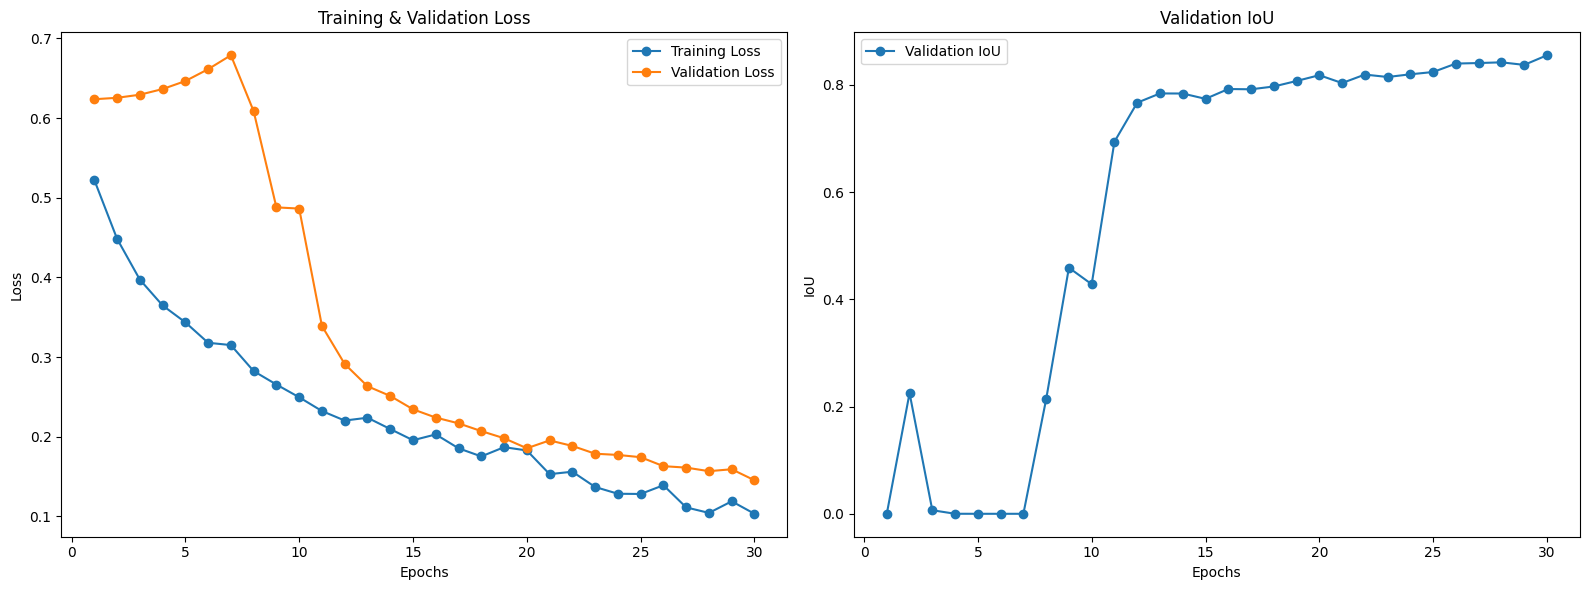

In [228]:
visualize_metrics(train_losses, valid_losses, valid_iou_scores, epochs=epochs)

Test Loss: 0.1540 Average IoU: 0.8383


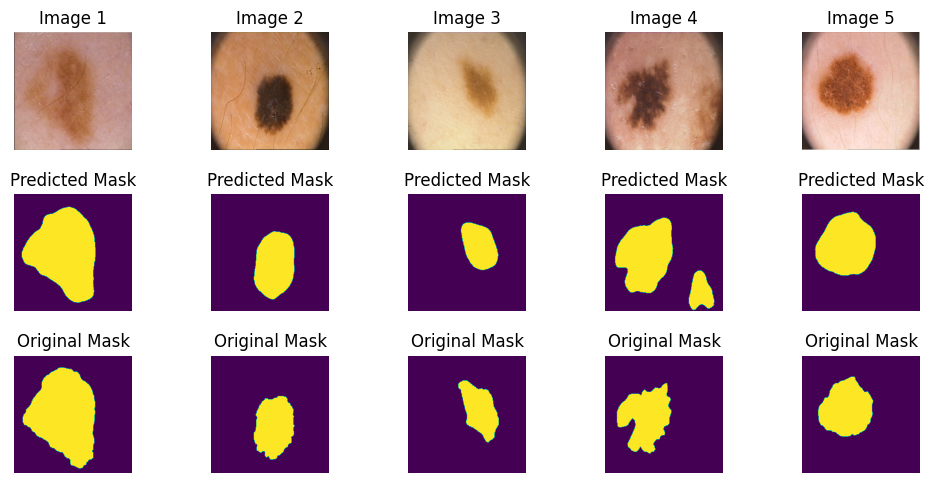

In [229]:
segnet_model = SegNet().to(device)
segnet_model.load_state_dict(torch.load('SegNet_epoch_30.pt', weights_only=True))
test(segnet_model, test_dataloader, criterion, device)

### Focal Loss

In [230]:
segnet_model = SegNet().to(device)
criterion = FocalLoss(mode='binary')
optimizer = optim.Adam(segnet_model.parameters(), lr=1e-4)
train_losses, valid_losses, valid_iou_scores = train(
    segnet_model,
    train_dataloader,
    valid_dataloader,
    criterion,
    optimizer,
    device,
    epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/30] Training Loss: 0.1841 Validation Loss: 0.1689 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/30] Training Loss: 0.1485 Validation Loss: 0.1668 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/30] Training Loss: 0.1058 Validation Loss: 0.1618 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/30] Training Loss: 0.0784 Validation Loss: 0.1566 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/30] Training Loss: 0.0674 Validation Loss: 0.1577 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/30] Training Loss: 0.0648 Validation Loss: 0.1721 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/30] Training Loss: 0.0641 Validation Loss: 0.2014 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/30] Training Loss: 0.0634 Validation Loss: 0.2403 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/30] Training Loss: 0.0612 Validation Loss: 0.2291 Validation IoU: 0.0506


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/30] Training Loss: 0.0465 Validation Loss: 0.1388 Validation IoU: 0.3829


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/30] Training Loss: 0.0478 Validation Loss: 0.0954 Validation IoU: 0.5989


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/30] Training Loss: 0.0388 Validation Loss: 0.0639 Validation IoU: 0.7384


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/30] Training Loss: 0.0447 Validation Loss: 0.0530 Validation IoU: 0.7825


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/30] Training Loss: 0.0344 Validation Loss: 0.0492 Validation IoU: 0.7901


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/30] Training Loss: 0.0300 Validation Loss: 0.0462 Validation IoU: 0.8011


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/30] Training Loss: 0.0239 Validation Loss: 0.0439 Validation IoU: 0.8170


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/30] Training Loss: 0.0346 Validation Loss: 0.0493 Validation IoU: 0.8070


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/30] Training Loss: 0.0393 Validation Loss: 0.0492 Validation IoU: 0.8095


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/30] Training Loss: 0.0395 Validation Loss: 0.0474 Validation IoU: 0.8084


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/30] Training Loss: 0.0392 Validation Loss: 0.0559 Validation IoU: 0.8001


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/30] Training Loss: 0.0371 Validation Loss: 0.0422 Validation IoU: 0.8250


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/30] Training Loss: 0.0295 Validation Loss: 0.0439 Validation IoU: 0.8178


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/30] Training Loss: 0.0262 Validation Loss: 0.0408 Validation IoU: 0.8292


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/30] Training Loss: 0.0252 Validation Loss: 0.0441 Validation IoU: 0.8163


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/30] Training Loss: 0.0218 Validation Loss: 0.0435 Validation IoU: 0.8215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/30] Training Loss: 0.0191 Validation Loss: 0.0459 Validation IoU: 0.8135


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/30] Training Loss: 0.0193 Validation Loss: 0.0430 Validation IoU: 0.8190


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/30] Training Loss: 0.0165 Validation Loss: 0.0403 Validation IoU: 0.8374


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/30] Training Loss: 0.0232 Validation Loss: 0.0464 Validation IoU: 0.8188


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/30] Training Loss: 0.0177 Validation Loss: 0.0484 Validation IoU: 0.8171


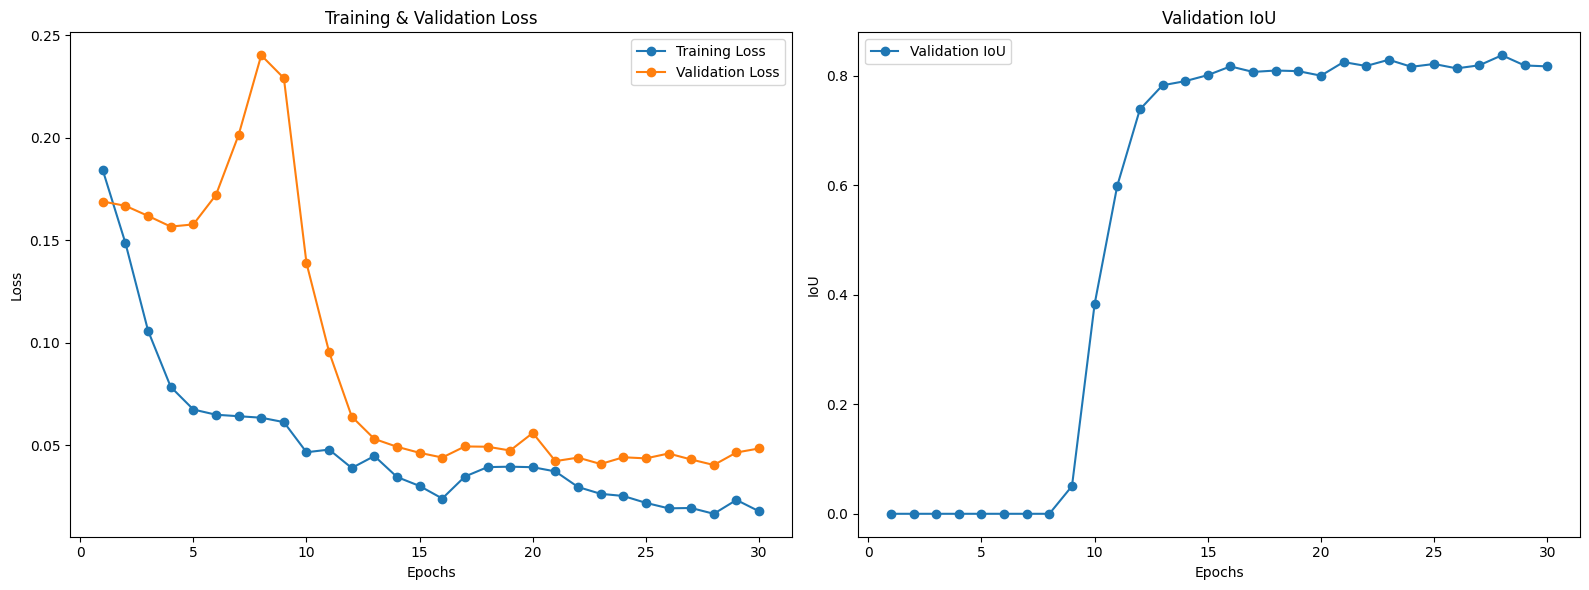

In [231]:
visualize_metrics(train_losses, valid_losses, valid_iou_scores, epochs=epochs)

Test Loss: 0.0325 Average IoU: 0.8527


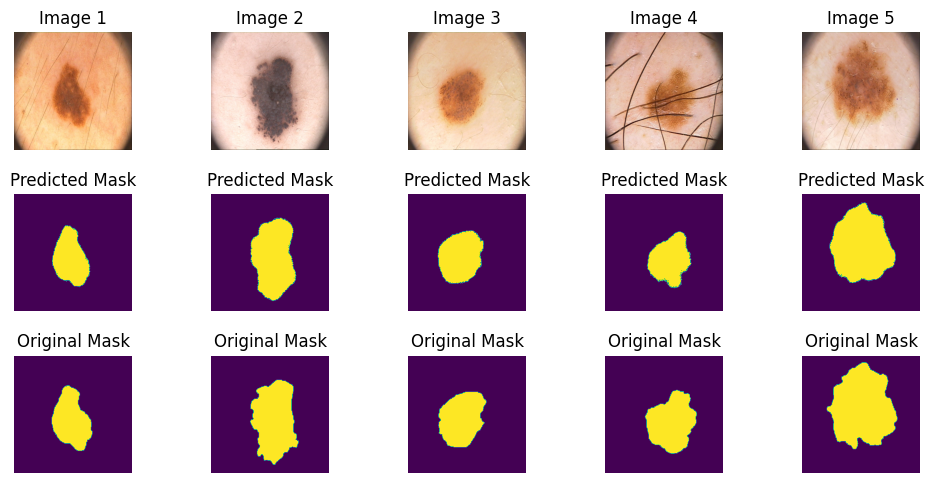

In [232]:
segnet_model = SegNet().to(device)
segnet_model.load_state_dict(torch.load('SegNet_epoch_29.pt', weights_only=True))
test(segnet_model, test_dataloader, criterion, device)

### Custom Tversky Loss

In [233]:
def tversky_loss(logits, labels, alpha=0.7, beta=0.3, smooth=1e-10):
    probs = torch.sigmoid(logits)

    TP = torch.sum(probs * labels)
    FP = torch.sum(probs * (1 - labels))
    FN = torch.sum((1 - probs) * labels)

    tversky_index = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    loss = 1 - tversky_index

    return loss

In [234]:
class CustomTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, smooth=1e-10):
        super(CustomTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, logits, labels):
        return tversky_loss(logits, labels, self.alpha, self.beta, self.smooth)

In [235]:
segnet_model = SegNet().to(device)
criterion = CustomTverskyLoss()
optimizer = optim.Adam(segnet_model.parameters(), lr=1e-4)
train_losses, valid_losses, valid_iou_scores = train(
    segnet_model,
    train_dataloader,
    valid_dataloader,
    criterion,
    optimizer,
    device,
    epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/30] Training Loss: 0.6286 Validation Loss: 0.6606 Validation IoU: 0.1825


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/30] Training Loss: 0.6034 Validation Loss: 0.6587 Validation IoU: 0.2596


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/30] Training Loss: 0.5368 Validation Loss: 0.6615 Validation IoU: 0.0052


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/30] Training Loss: 0.4542 Validation Loss: 0.6682 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/30] Training Loss: 0.4017 Validation Loss: 0.6822 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/30] Training Loss: 0.3767 Validation Loss: 0.7006 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/30] Training Loss: 0.3367 Validation Loss: 0.7304 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/30] Training Loss: 0.3044 Validation Loss: 0.7529 Validation IoU: 0.0016


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/30] Training Loss: 0.2773 Validation Loss: 0.4821 Validation IoU: 0.3923


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/30] Training Loss: 0.2528 Validation Loss: 0.3236 Validation IoU: 0.6303


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/30] Training Loss: 0.2352 Validation Loss: 0.2642 Validation IoU: 0.7470


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/30] Training Loss: 0.2170 Validation Loss: 0.2378 Validation IoU: 0.7677


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/30] Training Loss: 0.2072 Validation Loss: 0.2196 Validation IoU: 0.7869


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/30] Training Loss: 0.1863 Validation Loss: 0.2012 Validation IoU: 0.8037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/30] Training Loss: 0.1735 Validation Loss: 0.2102 Validation IoU: 0.7696


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/30] Training Loss: 0.1568 Validation Loss: 0.1882 Validation IoU: 0.8022


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/30] Training Loss: 0.1679 Validation Loss: 0.1736 Validation IoU: 0.8192


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/30] Training Loss: 0.1455 Validation Loss: 0.1830 Validation IoU: 0.7940


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/30] Training Loss: 0.1450 Validation Loss: 0.1652 Validation IoU: 0.8135


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/30] Training Loss: 0.1200 Validation Loss: 0.1596 Validation IoU: 0.8179


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/30] Training Loss: 0.1071 Validation Loss: 0.1560 Validation IoU: 0.8268


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/30] Training Loss: 0.1066 Validation Loss: 0.1430 Validation IoU: 0.8358


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/30] Training Loss: 0.1180 Validation Loss: 0.1607 Validation IoU: 0.8220


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/30] Training Loss: 0.1071 Validation Loss: 0.1512 Validation IoU: 0.8310


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/30] Training Loss: 0.1195 Validation Loss: 0.1495 Validation IoU: 0.8274


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/30] Training Loss: 0.1008 Validation Loss: 0.2086 Validation IoU: 0.7404


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/30] Training Loss: 0.1083 Validation Loss: 0.1271 Validation IoU: 0.8404


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/30] Training Loss: 0.0903 Validation Loss: 0.1549 Validation IoU: 0.8104


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/30] Training Loss: 0.0849 Validation Loss: 0.1248 Validation IoU: 0.8306


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/30] Training Loss: 0.0866 Validation Loss: 0.1429 Validation IoU: 0.8181


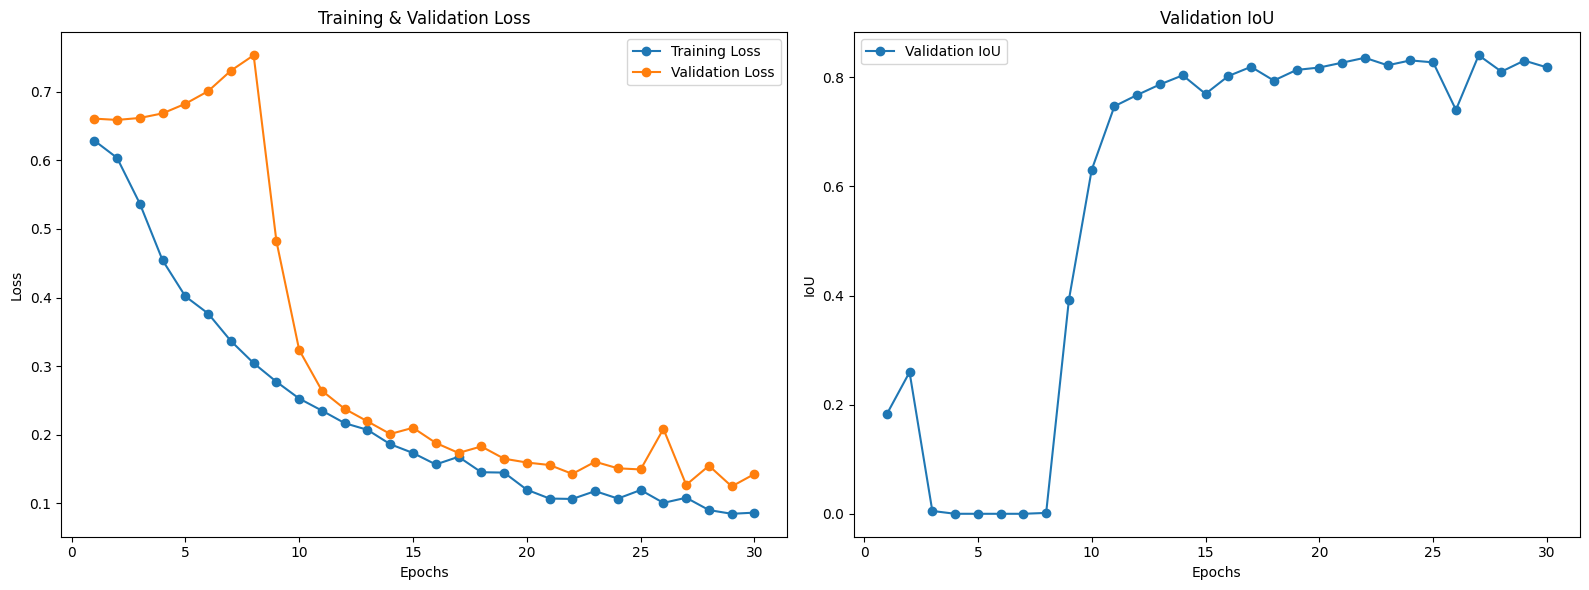

In [236]:
visualize_metrics(train_losses, valid_losses, valid_iou_scores, epochs=epochs)

Test Loss: 0.1573 Average IoU: 0.8186


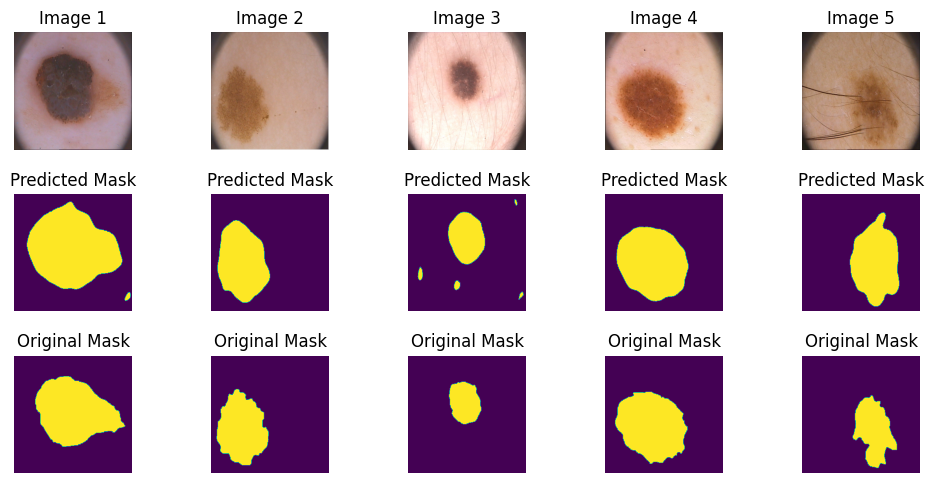

In [237]:
segnet_model = SegNet().to(device)
segnet_model.load_state_dict(torch.load('SegNet_epoch_30.pt', weights_only=True))
test(segnet_model, test_dataloader, criterion, device)

**Вывод:**
- модель `SegNet` показала более быструю сходимостьпри `Focal Loss1`
- при `BCEWithLogitsLoss` модель выдает наилучшую метрику `IoU` на тестовой выборке - **0,867**. При этом разброс значений метрики на остальных функциях потерь весьма небольшой


## Реализация модели U-Net

### U-Net архитектура

In [238]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        # Output layer
        output = torch.sigmoid(self.out(dec1))

        return output

In [239]:
unet_model = UNet().to(device)

### Обучение U-Net на разных лоссах

#### BCE Loss

In [240]:
unet_model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)
train_losses, valid_losses, valid_iou_scores = train(
    unet_model,
    train_dataloader,
    valid_dataloader,
    criterion,
    optimizer,
    device,
    epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/30] Training Loss: 0.7710 Validation Loss: 0.8152 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/30] Training Loss: 0.7261 Validation Loss: 0.8118 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/30] Training Loss: 0.7019 Validation Loss: 0.8033 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/30] Training Loss: 0.6860 Validation Loss: 0.7870 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/30] Training Loss: 0.6697 Validation Loss: 0.7657 Validation IoU: 0.2187


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/30] Training Loss: 0.6582 Validation Loss: 0.7373 Validation IoU: 0.2731


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/30] Training Loss: 0.6515 Validation Loss: 0.7075 Validation IoU: 0.3767


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/30] Training Loss: 0.6424 Validation Loss: 0.6905 Validation IoU: 0.4734


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/30] Training Loss: 0.6400 Validation Loss: 0.6800 Validation IoU: 0.6787


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/30] Training Loss: 0.6405 Validation Loss: 0.6720 Validation IoU: 0.7224


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/30] Training Loss: 0.6393 Validation Loss: 0.6620 Validation IoU: 0.7723


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/30] Training Loss: 0.6362 Validation Loss: 0.6743 Validation IoU: 0.7463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/30] Training Loss: 0.6352 Validation Loss: 0.6552 Validation IoU: 0.8097


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/30] Training Loss: 0.6357 Validation Loss: 0.6519 Validation IoU: 0.7930


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/30] Training Loss: 0.6286 Validation Loss: 0.6524 Validation IoU: 0.8200


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/30] Training Loss: 0.6273 Validation Loss: 0.6497 Validation IoU: 0.8288


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/30] Training Loss: 0.6267 Validation Loss: 0.6509 Validation IoU: 0.8314


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/30] Training Loss: 0.6256 Validation Loss: 0.6525 Validation IoU: 0.8480


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/30] Training Loss: 0.6228 Validation Loss: 0.6527 Validation IoU: 0.8415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/30] Training Loss: 0.6209 Validation Loss: 0.6491 Validation IoU: 0.8413


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/30] Training Loss: 0.6214 Validation Loss: 0.6479 Validation IoU: 0.8325


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/30] Training Loss: 0.6227 Validation Loss: 0.6467 Validation IoU: 0.8486


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/30] Training Loss: 0.6197 Validation Loss: 0.6447 Validation IoU: 0.8424


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/30] Training Loss: 0.6207 Validation Loss: 0.6439 Validation IoU: 0.8434


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/30] Training Loss: 0.6193 Validation Loss: 0.6457 Validation IoU: 0.8424


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/30] Training Loss: 0.6225 Validation Loss: 0.6445 Validation IoU: 0.8443


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/30] Training Loss: 0.6200 Validation Loss: 0.6489 Validation IoU: 0.8286


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/30] Training Loss: 0.6184 Validation Loss: 0.6436 Validation IoU: 0.8555


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/30] Training Loss: 0.6156 Validation Loss: 0.6436 Validation IoU: 0.8521


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/30] Training Loss: 0.6159 Validation Loss: 0.6437 Validation IoU: 0.8474


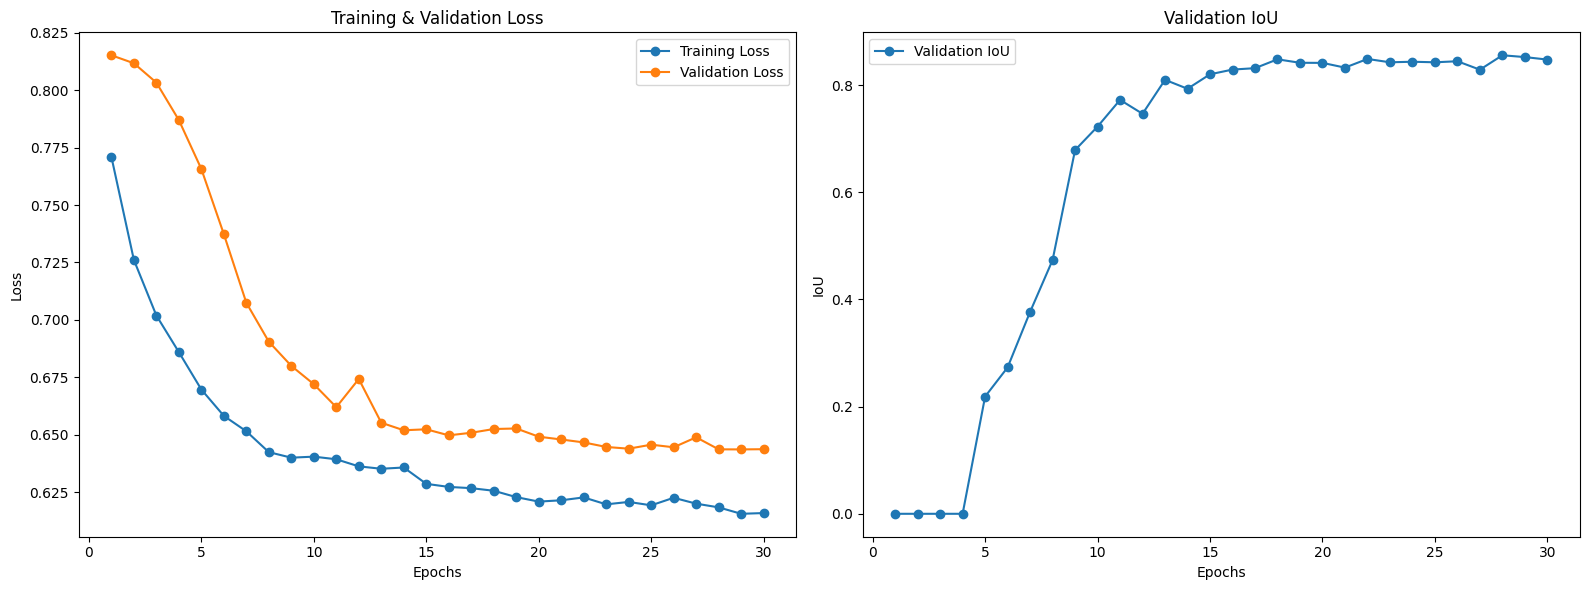

In [241]:
visualize_metrics(train_losses, valid_losses, valid_iou_scores, epochs=epochs)

Test Loss: 0.6478 Average IoU: 0.8722


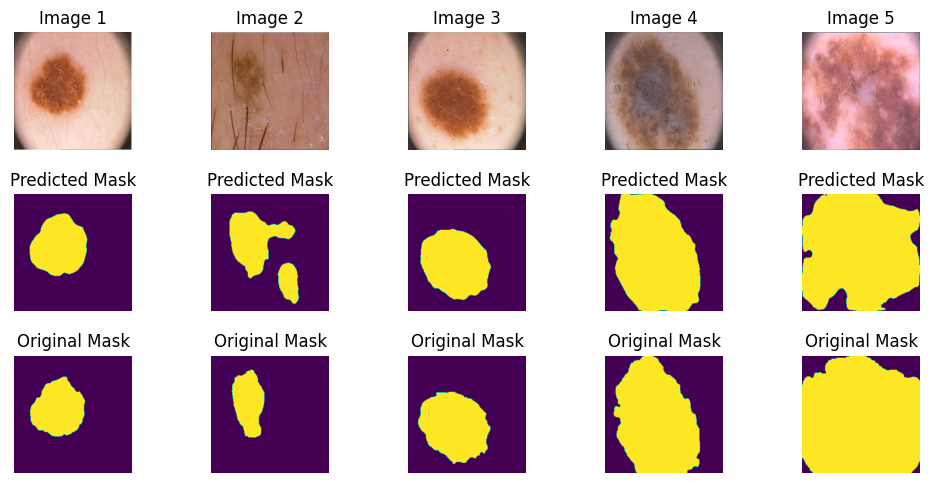

In [242]:
unet_model = UNet().to(device)
unet_model.load_state_dict(torch.load('UNet_epoch_30.pt', weights_only=True))
test(unet_model, test_dataloader, criterion, device)

#### Dice Loss

In [243]:
unet_model = UNet().to(device)
criterion = DiceLoss(mode='binary')
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)
train_losses, valid_losses, valid_iou_scores = train(
    unet_model,
    train_dataloader,
    valid_dataloader,
    criterion,
    optimizer,
    device,
    epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/30] Training Loss: 0.5332 Validation Loss: 0.5931 Validation IoU: 0.3003


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/30] Training Loss: 0.5171 Validation Loss: 0.5956 Validation IoU: 0.3003


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/30] Training Loss: 0.5073 Validation Loss: 0.5919 Validation IoU: 0.3517


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/30] Training Loss: 0.5040 Validation Loss: 0.5911 Validation IoU: 0.4626


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/30] Training Loss: 0.4965 Validation Loss: 0.5896 Validation IoU: 0.3172


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/30] Training Loss: 0.4947 Validation Loss: 0.5930 Validation IoU: 0.0768


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/30] Training Loss: 0.4947 Validation Loss: 0.5938 Validation IoU: 0.1172


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/30] Training Loss: 0.4876 Validation Loss: 0.5997 Validation IoU: 0.0954


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/30] Training Loss: 0.4844 Validation Loss: 0.5951 Validation IoU: 0.1323


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/30] Training Loss: 0.4827 Validation Loss: 0.5700 Validation IoU: 0.5956


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/30] Training Loss: 0.4822 Validation Loss: 0.5391 Validation IoU: 0.7580


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/30] Training Loss: 0.4801 Validation Loss: 0.5376 Validation IoU: 0.7723


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/30] Training Loss: 0.4810 Validation Loss: 0.5337 Validation IoU: 0.8040


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/30] Training Loss: 0.4789 Validation Loss: 0.5314 Validation IoU: 0.7958


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/30] Training Loss: 0.4797 Validation Loss: 0.5327 Validation IoU: 0.8256


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/30] Training Loss: 0.4796 Validation Loss: 0.5264 Validation IoU: 0.8329


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/30] Training Loss: 0.4770 Validation Loss: 0.5266 Validation IoU: 0.8192


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/30] Training Loss: 0.4817 Validation Loss: 0.5242 Validation IoU: 0.8258


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/30] Training Loss: 0.4771 Validation Loss: 0.5252 Validation IoU: 0.8027


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/30] Training Loss: 0.4794 Validation Loss: 0.5286 Validation IoU: 0.7863


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/30] Training Loss: 0.4788 Validation Loss: 0.5295 Validation IoU: 0.7974


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/30] Training Loss: 0.4752 Validation Loss: 0.5226 Validation IoU: 0.8278


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/30] Training Loss: 0.4765 Validation Loss: 0.5235 Validation IoU: 0.8301


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/30] Training Loss: 0.4755 Validation Loss: 0.5245 Validation IoU: 0.8193


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/30] Training Loss: 0.4768 Validation Loss: 0.5292 Validation IoU: 0.7687


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/30] Training Loss: 0.4748 Validation Loss: 0.5334 Validation IoU: 0.8199


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/30] Training Loss: 0.4748 Validation Loss: 0.5261 Validation IoU: 0.8231


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/30] Training Loss: 0.4772 Validation Loss: 0.5240 Validation IoU: 0.8040


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/30] Training Loss: 0.4728 Validation Loss: 0.5219 Validation IoU: 0.8329


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/30] Training Loss: 0.4726 Validation Loss: 0.5300 Validation IoU: 0.8393


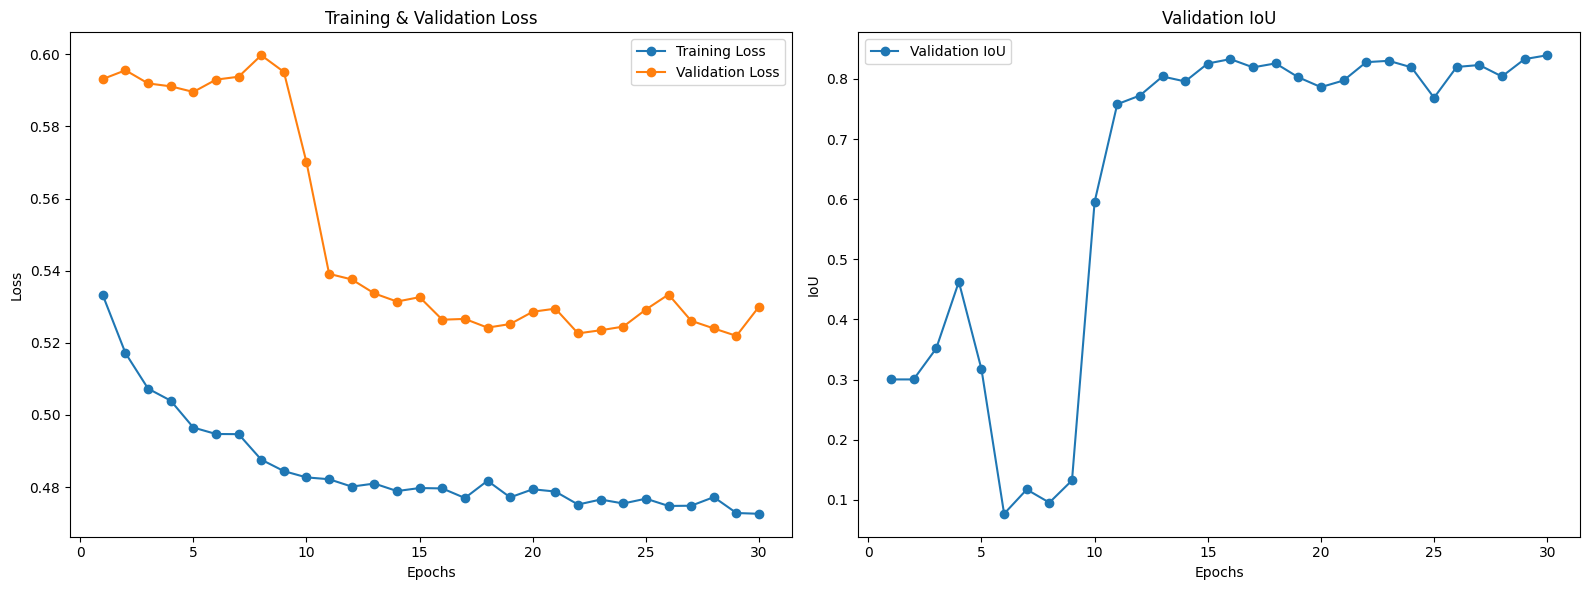

In [244]:
visualize_metrics(train_losses, valid_losses, valid_iou_scores, epochs=epochs)

Test Loss: 0.5344 Average IoU: 0.8254


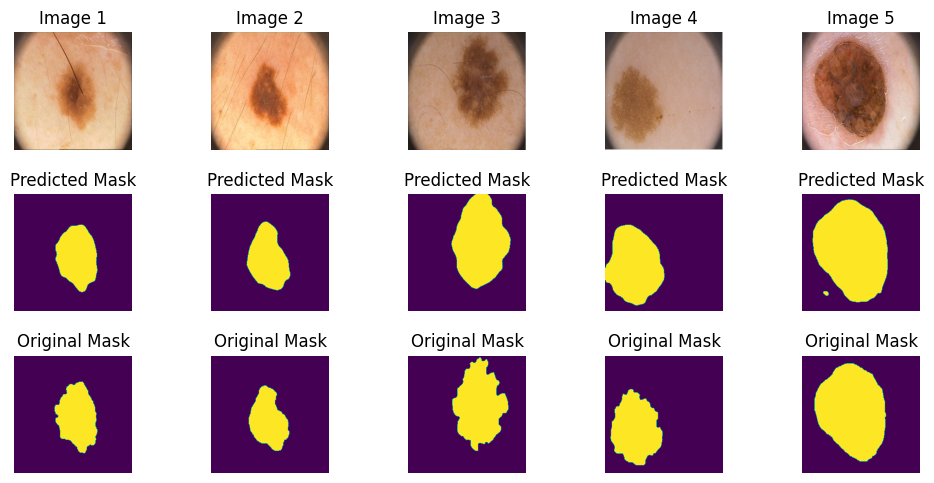

In [245]:
unet_model = UNet().to(device)
unet_model.load_state_dict(torch.load('UNet_epoch_30.pt', weights_only=True), strict=False)
test(unet_model, test_dataloader, criterion, device)

#### Focal Loss

In [246]:
unet_model = UNet().to(device)
criterion = FocalLoss(mode='binary')
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)
train_losses, valid_losses, valid_iou_scores = train(
    unet_model,
    train_dataloader,
    valid_dataloader,
    criterion,
    optimizer,
    device,
    epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/30] Training Loss: 0.2574 Validation Loss: 0.2818 Validation IoU: 0.0006


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/30] Training Loss: 0.2293 Validation Loss: 0.2738 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/30] Training Loss: 0.2132 Validation Loss: 0.2623 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/30] Training Loss: 0.2025 Validation Loss: 0.2485 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/30] Training Loss: 0.1940 Validation Loss: 0.2351 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/30] Training Loss: 0.1896 Validation Loss: 0.2223 Validation IoU: 0.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/30] Training Loss: 0.1868 Validation Loss: 0.2103 Validation IoU: 0.0017


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/30] Training Loss: 0.1851 Validation Loss: 0.2033 Validation IoU: 0.1802


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/30] Training Loss: 0.1813 Validation Loss: 0.1934 Validation IoU: 0.5671


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/30] Training Loss: 0.1815 Validation Loss: 0.1932 Validation IoU: 0.6668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/30] Training Loss: 0.1813 Validation Loss: 0.1883 Validation IoU: 0.7305


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/30] Training Loss: 0.1792 Validation Loss: 0.1873 Validation IoU: 0.7868


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/30] Training Loss: 0.1776 Validation Loss: 0.1866 Validation IoU: 0.8231


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/30] Training Loss: 0.1778 Validation Loss: 0.1823 Validation IoU: 0.8394


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/30] Training Loss: 0.1762 Validation Loss: 0.1820 Validation IoU: 0.8338


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/30] Training Loss: 0.1742 Validation Loss: 0.1807 Validation IoU: 0.8149


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/30] Training Loss: 0.1739 Validation Loss: 0.1817 Validation IoU: 0.8066


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/30] Training Loss: 0.1742 Validation Loss: 0.1856 Validation IoU: 0.8313


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/30] Training Loss: 0.1747 Validation Loss: 0.1823 Validation IoU: 0.8400


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/30] Training Loss: 0.1726 Validation Loss: 0.1832 Validation IoU: 0.8468


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/30] Training Loss: 0.1710 Validation Loss: 0.1839 Validation IoU: 0.8441


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/30] Training Loss: 0.1700 Validation Loss: 0.1829 Validation IoU: 0.8473


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/30] Training Loss: 0.1699 Validation Loss: 0.1810 Validation IoU: 0.8459


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/30] Training Loss: 0.1700 Validation Loss: 0.1805 Validation IoU: 0.8500


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/30] Training Loss: 0.1678 Validation Loss: 0.1815 Validation IoU: 0.8565


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/30] Training Loss: 0.1686 Validation Loss: 0.1808 Validation IoU: 0.8387


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/30] Training Loss: 0.1685 Validation Loss: 0.1788 Validation IoU: 0.8304


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/30] Training Loss: 0.1672 Validation Loss: 0.1811 Validation IoU: 0.8519


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/30] Training Loss: 0.1680 Validation Loss: 0.1791 Validation IoU: 0.8482


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/30] Training Loss: 0.1665 Validation Loss: 0.1771 Validation IoU: 0.8541


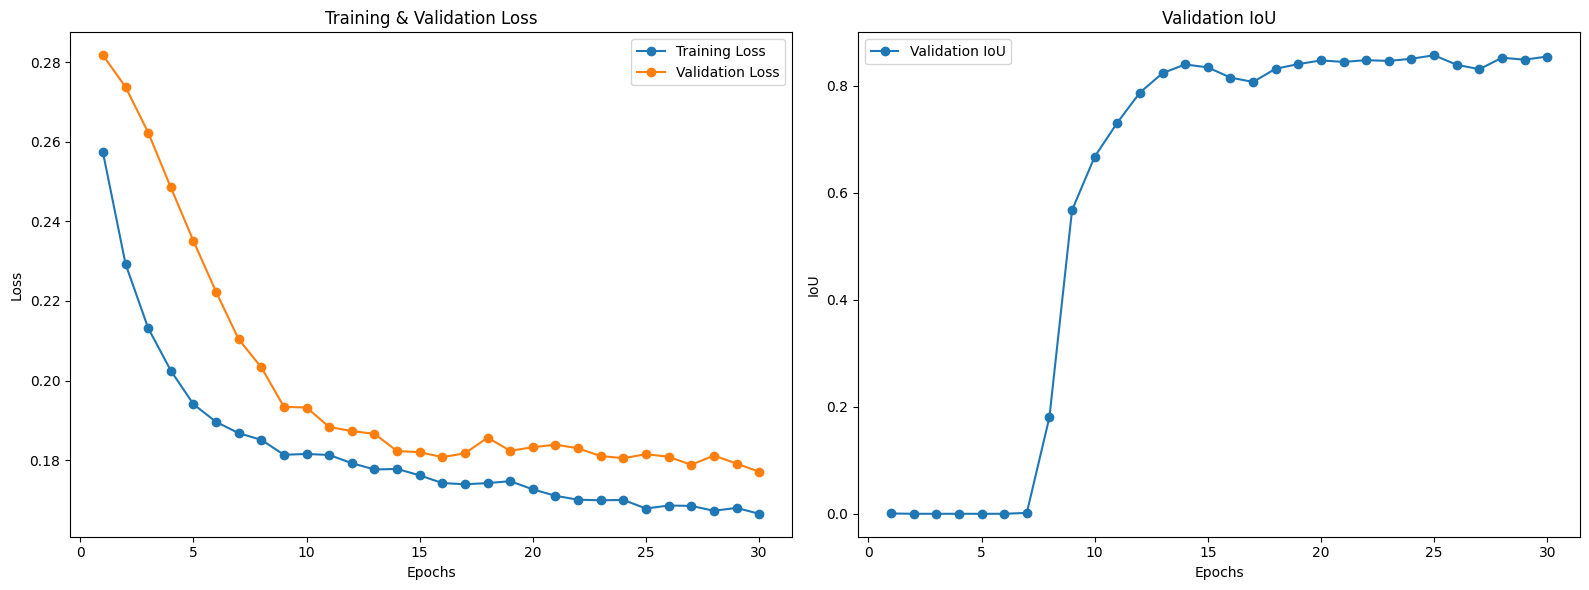

In [247]:
visualize_metrics(train_losses, valid_losses, valid_iou_scores, epochs=epochs)

Test Loss: 0.1833 Average IoU: 0.8654


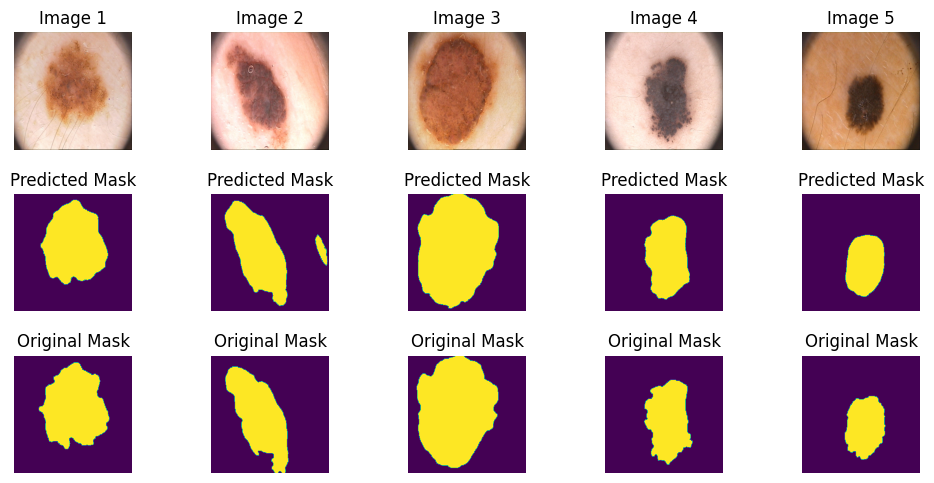

In [248]:
unet_model = UNet().to(device)
unet_model.load_state_dict(torch.load('UNet_epoch_30.pt', weights_only=True))
test(unet_model, test_dataloader, criterion, device)

#### Custom Tversky Loss

In [249]:
unet_model = UNet().to(device)
criterion = CustomTverskyLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)
train_losses, valid_losses, valid_iou_scores = train(
    unet_model,
    train_dataloader,
    valid_dataloader,
    criterion,
    optimizer,
    device,
    epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/30] Training Loss: 0.5870 Validation Loss: 0.6441 Validation IoU: 0.3003


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/30] Training Loss: 0.5685 Validation Loss: 0.6436 Validation IoU: 0.3003


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/30] Training Loss: 0.5587 Validation Loss: 0.6432 Validation IoU: 0.5125


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/30] Training Loss: 0.5511 Validation Loss: 0.6447 Validation IoU: 0.3259


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/30] Training Loss: 0.5465 Validation Loss: 0.6407 Validation IoU: 0.1766


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/30] Training Loss: 0.5426 Validation Loss: 0.6350 Validation IoU: 0.2454


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/30] Training Loss: 0.5396 Validation Loss: 0.6258 Validation IoU: 0.3617


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/30] Training Loss: 0.5391 Validation Loss: 0.6178 Validation IoU: 0.4405


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/30] Training Loss: 0.5362 Validation Loss: 0.6063 Validation IoU: 0.5995


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/30] Training Loss: 0.5348 Validation Loss: 0.5894 Validation IoU: 0.7312


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/30] Training Loss: 0.5330 Validation Loss: 0.5909 Validation IoU: 0.7355


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/30] Training Loss: 0.5326 Validation Loss: 0.5868 Validation IoU: 0.7970


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/30] Training Loss: 0.5313 Validation Loss: 0.5892 Validation IoU: 0.7728


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/30] Training Loss: 0.5315 Validation Loss: 0.5880 Validation IoU: 0.7940


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/30] Training Loss: 0.5294 Validation Loss: 0.5872 Validation IoU: 0.8093


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/30] Training Loss: 0.5315 Validation Loss: 0.5863 Validation IoU: 0.8216


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/30] Training Loss: 0.5310 Validation Loss: 0.5846 Validation IoU: 0.8202


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/30] Training Loss: 0.5293 Validation Loss: 0.5864 Validation IoU: 0.7764


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/30] Training Loss: 0.5291 Validation Loss: 0.5826 Validation IoU: 0.8224


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/30] Training Loss: 0.5276 Validation Loss: 0.5886 Validation IoU: 0.8183


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/30] Training Loss: 0.5270 Validation Loss: 0.5848 Validation IoU: 0.8099


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/30] Training Loss: 0.5286 Validation Loss: 0.5834 Validation IoU: 0.8318


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/30] Training Loss: 0.5264 Validation Loss: 0.5846 Validation IoU: 0.8116


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/30] Training Loss: 0.5277 Validation Loss: 0.5835 Validation IoU: 0.8168


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/30] Training Loss: 0.5264 Validation Loss: 0.5818 Validation IoU: 0.8469


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/30] Training Loss: 0.5263 Validation Loss: 0.5833 Validation IoU: 0.8007


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/30] Training Loss: 0.5257 Validation Loss: 0.5825 Validation IoU: 0.7927


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/30] Training Loss: 0.5255 Validation Loss: 0.5823 Validation IoU: 0.7957


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/30] Training Loss: 0.5258 Validation Loss: 0.5806 Validation IoU: 0.8283


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/30] Training Loss: 0.5238 Validation Loss: 0.5821 Validation IoU: 0.8404


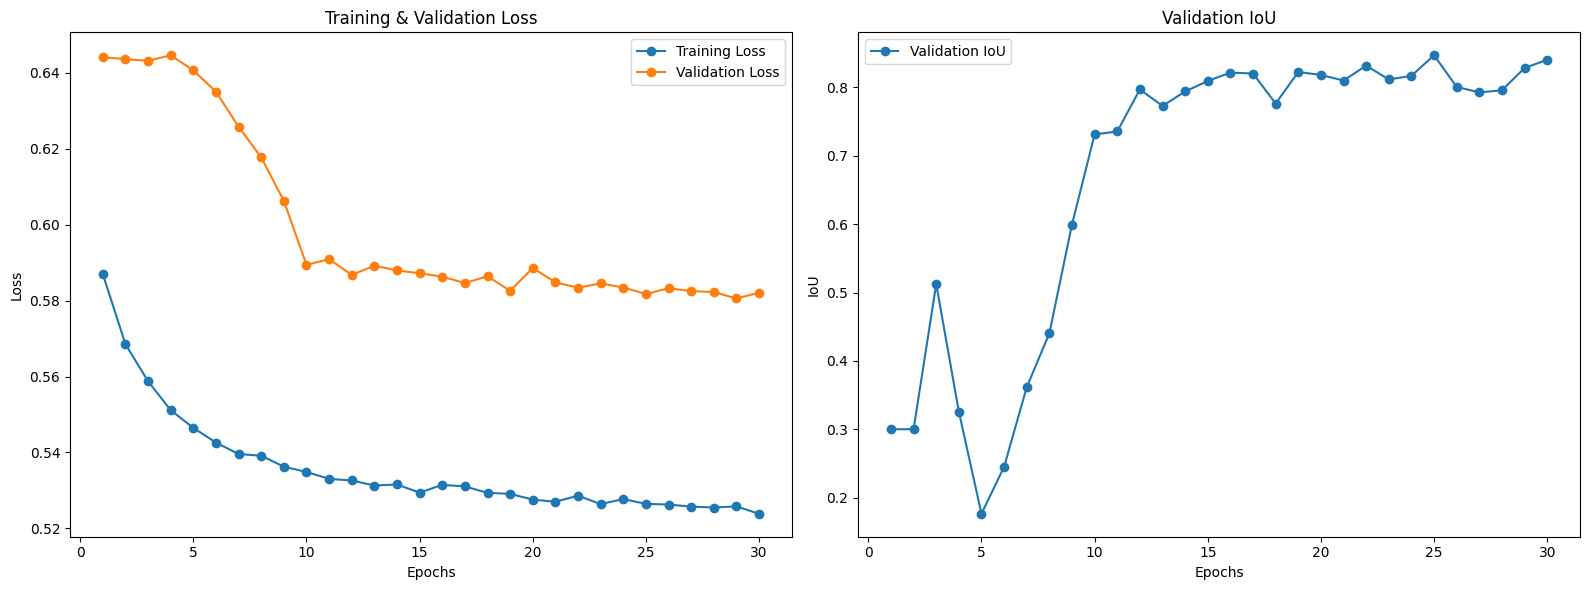

In [250]:
visualize_metrics(train_losses, valid_losses, valid_iou_scores, epochs=epochs)

Test Loss: 0.5931 Average IoU: 0.8380


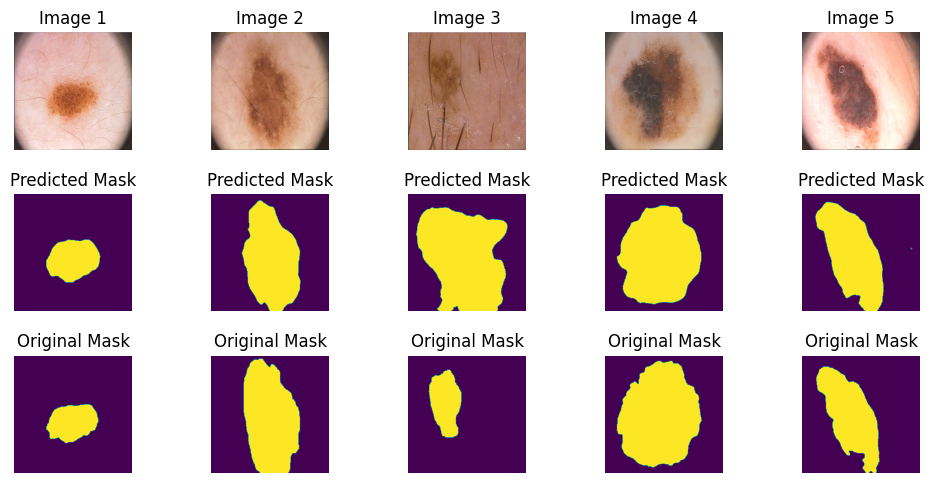

In [251]:
unet_model = UNet().to(device)
unet_model.load_state_dict(torch.load('UNet_epoch_29.pt', weights_only=True))
test(unet_model, test_dataloader, criterion, device)

1. В среднем модель SegNet показала более высокие значения метрики IoU за 30 эпох, чем UNet. При должной настройке Unet и увеличении количества эпох, думаю, можно будет добиться более высоких значений метрик за счет наличия skip-connections в модели.

2. В соответствии со значениями метрики, значения лоссов чуть лучше на модели SegNet, но незначительно.

3. Модель SegNet обучается немного быстрее из-за более простой архитектуры.